In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!unzip /content/gdrive/My\ Drive/Flickr8k_Dataset.zip
!unzip /content/gdrive/My\ Drive/Flickr8k_text.zip

In [1]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import cv2
import re
import os

In [2]:
images_path = '/content/Flicker8k_Dataset/'
description_path = '/content/Flickr8k.token.txt'

In [3]:
num_samples = 12000

In [4]:
def load_description(description_path):
    pathFile = open(description_path)
    f = pathFile.read()
    final = f.split('\n')
    return final

In [5]:
description_file = load_description(description_path)

In [6]:
def text_preprocess(text):
    image_caption = re.sub("[^a-zA-Z0-9]", " ", text)
    image_caption = re.sub('  ', '', image_caption)
    image_caption = [word.lower() for word in image_caption]
    image_caption = ''.join(image_caption)
    image_caption = 'start_ ' + image_caption + ' _end'
    return image_caption

In [7]:
def create_description(description_file):
    descriptions = defaultdict(list)
    for i in tqdm(range(num_samples)):
        image_id = description_file[i].split('\t')[0][:-2]
        image_caption = description_file[i].split('\t')[1]
        preprocessed_text = text_preprocess(image_caption)
        if image_id in descriptions.keys():
            descriptions[image_id].append(preprocessed_text)
        else: descriptions[image_id].append(preprocessed_text)
    return descriptions

In [8]:
descriptions = create_description(description_file)

100%|██████████| 12000/12000 [00:00<00:00, 84564.29it/s]


In [9]:
tokenizer = Tokenizer(filters='')

In [10]:
#creating whole captions corpus for tokenizer training

def create_tokenizer(description_file, tokenizer):
    captions = []
    for line in tqdm(description_file[:num_samples]):
        caption = line.split('\t')[1]
        caption = text_preprocess(caption)
        captions.append(caption)

    tokenizer.fit_on_texts(captions)
    vocab_size = len(tokenizer.word_index)+1
    
    return vocab_size, tokenizer

In [11]:
vocab_size, tokenizer = create_tokenizer(description_file, tokenizer)

100%|██████████| 12000/12000 [00:00<00:00, 94716.79it/s]


In [12]:
#creating sequences for training
def create_sequences(descriptions, tokenizer, features, vocab_size):
    images_features = []
    input_seq = []
    output_seq = []

    for key, value in tqdm(descriptions.items()):
        if str(key) == '2258277193_586949ec62.jpg.1':
            continue
        for caption in value:
            encoded_caption = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(encoded_caption)):
                images_features.append(features[key])
                in_seq, out_seq = encoded_caption[:i], encoded_caption[i]
                padded_in_seq = pad_sequences([in_seq], maxlen=50, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                input_seq.append(padded_in_seq)
                output_seq.append(out_seq)

    return np.array(images_features), np.array(input_seq), np.array(output_seq)


In [13]:
#extracting feature representations of images using transfer learning 

def process_images(images_path, image_names):
    
    resnetModel = resnet50.ResNet50(weights='imagenet', include_top=True, input_shape=(224,224,3))

    for layer in resnetModel.layers:
        layer.trainable = False

    #restructure model
    resnetModel.layers.pop()
    model = Model(inputs=resnetModel.input, outputs=resnetModel.layers[-2].output)

    features = {}
    for img_name in tqdm(image_names):
        if str(img_name) == '2258277193_586949ec62.jpg.1':
            continue
        img = cv2.imread(os.path.join(images_path, img_name))
        img = cv2.resize(img, (224, 224))
        img = img_to_array(img)
        img = img.reshape(1, 224, 224, 3)
        features_extracted = model.predict(img)
        features[img_name] = features_extracted

    return features

In [14]:
image_names = list(descriptions.keys())
features = process_images(images_path, image_names)

100%|██████████| 2400/2400 [02:03<00:00, 19.42it/s]


In [21]:
#preparing model

def encoder_decoder(vocab_size):
    #feature extractor model
    inputs1 = layers.Input(shape=(2048,))
    fe1 = layers.Dropout(0.5)(inputs1)
    fe2 = layers.Dense(256, activation='relu')(fe1)

    #sequence encoder model
    inputs2 = layers.Input(shape=(50,))
    se1 = layers.Embedding(vocab_size, 256)(inputs2)
    se2 = layers.Dropout(0.5)(se1)
    se3 = layers.LSTM(256)(se2)

    #decoder model
    de1 = layers.Add()([fe2, se3])
    de2 = layers.Dense(256, activation='relu')(de1)
    de3 = layers.Dense(vocab_size, activation='softmax')(de2)

    model = Model(inputs=[inputs1, inputs2], outputs=de3)

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()

    plot_model(model, to_file='/content/model.png', show_shapes=True)
    return model

In [22]:
CNN_RNN_model = encoder_decoder(vocab_size)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 256)      1229312     input_9[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_8[0][0]                    
_______________________________________________________________________________________

In [23]:
#preparing data for training

X_image_features, X_input_sequences, y_output_sequences = create_sequences(descriptions, tokenizer, features, vocab_size)
X_image_features = X_image_features.reshape(X_image_features.shape[0], X_image_features.shape[2])

100%|██████████| 2400/2400 [00:05<00:00, 404.61it/s]


In [23]:
X_image_features.shape, X_input_sequences.shape, y_output_sequences.shape

((142653, 2048), (142653, 50), (142653, 4802))

In [24]:
CNN_RNN_model.fit([X_image_features, X_input_sequences], y_output_sequences, epochs=25, verbose=1)

Epoch 1/25
4458/4458 [==============================] - 95s 21ms/step - loss: 5.2528
Epoch 2/25
4458/4458 [==============================] - 90s 20ms/step - loss: 5.0572
Epoch 3/25
4458/4458 [==============================] - 91s 20ms/step - loss: 4.9721
Epoch 4/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.9239
Epoch 5/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.8914
Epoch 6/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.8726
Epoch 7/25
4458/4458 [==============================] - 93s 21ms/step - loss: 4.8595
Epoch 8/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.8468
Epoch 9/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.6484
Epoch 10/25
4458/4458 [==============================] - 94s 21ms/step - loss: 4.1211
Epoch 11/25
4458/4458 [==============================] - 95s 21ms/step - loss: 3.7959
Epoch 12/25
4458/4458 [==============================] - 94s 21

In [26]:
CNN_RNN_model.save('/content/imageCaption.h5')

**INFERENCE/TESTING PART**

In [25]:
#loading image feature extractor model
resnetModel = resnet50.ResNet50(weights='imagenet', include_top=True, input_shape=(224,224,3))

for layer in resnetModel.layers:
    layer.trainable = False

#restructuring model
resnetModel.layers.pop()
image_feature_extractor = Model(inputs=resnetModel.input, outputs=resnetModel.layers[-2].output)

In [34]:
#loading CNN RNN Model
cnn_rnn_model = load_model('/content/imageCaption.h5')

In [28]:
def get_image_features(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    return model.predict(img)

In [44]:
# img_path = '/content/Flicker8k_Dataset/2098418613_85a0c9afea.jpg'
# img_path = '/content/gdrive/My Drive/cat.jpg'
# img_path = '/content/gdrive/My Drive/car.jpg'
img_path = '/content/gdrive/My Drive/swim.jpg'
img_feature = get_image_features(img_path, image_feature_extractor)

In [30]:
def generate_caption(img_feature, model):
    in_seq = 'start_' 
    for i in range(50):
        seq = tokenizer.texts_to_sequences([in_seq])[0]
        padded_text_seq = pad_sequences([seq], maxlen=50, padding='post')
        padded_arr_seq = np.array(padded_text_seq)
        prediction = model.predict(x=[img_feature, padded_arr_seq])
        prediction = np.argmax(prediction)
        word = tokenizer.index_word[prediction]
        in_seq += ' ' + word
        if word == '_end':
            break
    caption = in_seq.split()
    caption = caption[1:-1]
    caption = ' '.join(caption)
    return caption

In [45]:
caption = generate_caption(img_feature, cnn_rnn_model)

In [46]:
caption

'a man in a blue shirt is standing on a pool'

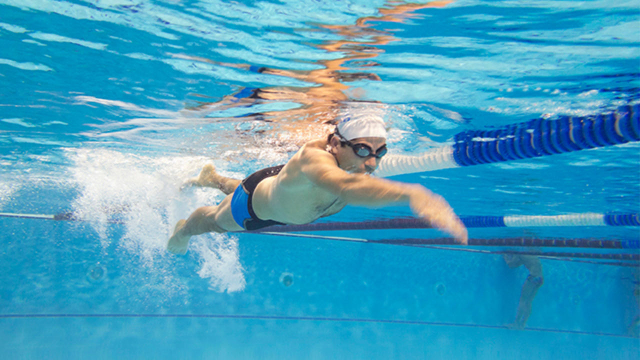

In [56]:
img = cv2.imread(img_path)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(img)